<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Análise-Exploratória-de-Dados-(EDA)" data-toc-modified-id="Análise-Exploratória-de-Dados-(EDA)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Análise Exploratória de Dados (EDA)</a></span><ul class="toc-item"><li><span><a href="#Definição-do-Problema" data-toc-modified-id="Definição-do-Problema-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Definição do Problema</a></span></li><li><span><a href="#Fonte-de-Dados" data-toc-modified-id="Fonte-de-Dados-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Fonte de Dados</a></span></li><li><span><a href="#Usando-Paletas-de-Cor" data-toc-modified-id="Usando-Paletas-de-Cor-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Usando Paletas de Cor</a></span></li><li><span><a href="#Distribuição-e-Evolução-de-Avaliações" data-toc-modified-id="Distribuição-e-Evolução-de-Avaliações-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Distribuição e Evolução de Avaliações</a></span></li><li><span><a href="#Explorando-(co)Relações" data-toc-modified-id="Explorando-(co)Relações-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Explorando (co)Relações</a></span></li><li><span><a href="#Relação-entre-uma-variável-continua-e-uma-categórica" data-toc-modified-id="Relação-entre-uma-variável-continua-e-uma-categórica-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Relação entre uma variável continua e uma categórica</a></span></li><li><span><a href="#Análises-multi-variáveis" data-toc-modified-id="Análises-multi-variáveis-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Análises multi-variáveis</a></span></li></ul></li></ul></div>

In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv("credentials/mysql.env")
url_banco = "localhost"
nome_db = "olist"
conn_str = f"mysql+pymysql://{os.getenv('MYSQL_USER')}:{os.getenv('MYSQL_PASS')}@{url_banco}/{nome_db}"
engine = create_engine(conn_str)


In [2]:
sns.set_theme(context="notebook", style="darkgrid")


Para facilitar nosso trabalho na aula de hoje, vamos criar um View com os dados que utilizaremos ao longo da aula.

# Análise Exploratória de Dados (EDA)

O processo de construção de modelos pode ser dividido em quatro etapas:

1. **Definição do Problema e Coleta de Dados**;
    * Todo modelo deve ter um **objetivo bem definido**.
    * O **tempo disponível** para construção é **parte da definição do problema**!
    * A partir desta definição podemos definir *quais dados serão necessários* para **iniciarmos nossa análise**.
1. **Análises Exploratórias**;
    * O objetivo da análise exploratória é *maximizar o nosso conhecimento* sobre a **estrutura dos dados** disponíveis, mapear as relações entre diferentes variáveis e o objetivo do nosso problema e **avaliar a qualidade dos dados**, eventualmente propondo tratativas para sanar problemas.
1. **Definição e construção do modelo**;
    * A partir do conhecimento adquirido durante a análise exploratória vamos determinar quais **técnicas são mais apropriadas** para a resolução do nosso problema.
    * Para escolher entre diferentes técnicas devemos **implantar uma infra-estrutura rudimentar de testes**, que nos permita *testar diferentes modelos de forma rápida e simples*.
1. **Validação e definição de próximos passos**.
    * Com a construção do modelo finalizada, conduziremos a validação final do modelo, apresentando os conceitos por trás deste para os diferentes stakeholders do projeto. Além disso conduziremos testes utilizando a infra-estrutura operacional do modelo, garantindo que não houve perda de performance nas condições operacionais.

Este processo **não é necessariamente linear**: podemos descobrir na etapa de análises exploratórias que não temos todas as informações necessárias para construir um modelo, ou então que as informações estão comprometidas a ponto de inviabilizar qualquer análise.

Hoje nos aprofundaremos na segunda etapa deste fluxo: a análise exploratória de dados!

## Definição do Problema

Para a aula de hoje utilizaremos o data set da Olist. Foi solicitado ao CoE de Dados que construa um modelo para explicar e prever variações nas avalições que clientes fizeram de nossos pedidos. O objetivo deste modelo é descobrir quais são os principais eixos que impactam estas avaliações para que possamos focar esforços na melhoria das áreas mais críticas.

Os dados utilizados serão os dados do case OLIST, disponíveis no nosso DB MySQL.

## Fonte de Dados

No caso da aula de hoje, utilizaremos o nosso DB MySQL como fonte de dados para nossa análise exploratória.

In [3]:
query = """
	SELECT
		oodc.order_id,
		ooidc.seller_id,
		ooidc.price,
		ooidc.freight_value,
		oodc.order_status,
		STR_TO_DATE(oodc.order_approved_at, '%%Y-%%m-%%d %%H:%%i:%%s') AS order_approved_at,
		STR_TO_DATE(ooidc.shipping_limit_date, '%%Y-%%m-%%d %%H:%%i:%%s') AS shipping_limit_date,
		STR_TO_DATE(oodc.order_delivered_carrier_date, '%%Y-%%m-%%d %%H:%%i:%%s') AS order_delivered_carrier_date,
		STR_TO_DATE(oodc.order_delivered_customer_date, '%%Y-%%m-%%d %%H:%%i:%%s') AS order_delivered_customer_date,
		STR_TO_DATE(oodc.order_estimated_delivery_date, '%%Y-%%m-%%d %%H:%%i:%%s') AS order_estimated_delivery_date,
		ocdc.customer_state,
		osdc.seller_state,
		opdc.product_category_name,
		opdc.product_weight_g,
		oordc.review_score 
	FROM 
		olist_order_items_dataset_csv ooidc JOIN
		olist_orders_dataset_csv oodc ON (ooidc.order_id = oodc.order_id) JOIN 
		olist_customers_dataset_csv ocdc ON (oodc.customer_id = ocdc.customer_id) JOIN 
		olist_products_dataset_csv opdc ON (ooidc.product_id = opdc.product_id) JOIN
		olist_sellers_dataset_csv osdc ON (osdc.seller_id = ooidc.seller_id) LEFT JOIN 
		olist_order_reviews_dataset_csv oordc ON (oodc.order_id = oordc.order_id) JOIN
		(
			SELECT
				oordc.review_id,
				STR_TO_DATE(oordc.review_creation_date, '%%Y-%%m-%%d %%H:%%i:%%s') AS review_date,
				SUM(1) OVER (PARTITION BY order_id ORDER BY order_id, STR_TO_DATE(oordc.review_creation_date, '%%Y-%%m-%%d %%H:%%i:%%s') DESC) AS cum_review
			FROM 
				olist_order_reviews_dataset_csv oordc
			ORDER BY 
				oordc.order_id,
				STR_TO_DATE(oordc.review_creation_date, '%%Y-%%m-%%d %%H:%%i:%%s') DESC
		) AS lr ON (oordc.review_id = lr.review_id)
	WHERE
		lr.cum_review = 1
	HAVING
		order_approved_at >= '2017-08-01' AND
		order_approved_at < '2018-08-01'
"""
tb_pedidos = pd.read_sql(query, engine)


In [4]:
tb_pedidos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66136 entries, 0 to 66135
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       66136 non-null  object        
 1   seller_id                      66136 non-null  object        
 2   price                          66136 non-null  float64       
 3   freight_value                  66136 non-null  float64       
 4   order_status                   66136 non-null  object        
 5   order_approved_at              66136 non-null  datetime64[ns]
 6   shipping_limit_date            66136 non-null  datetime64[ns]
 7   order_delivered_carrier_date   65536 non-null  datetime64[ns]
 8   order_delivered_customer_date  64881 non-null  datetime64[ns]
 9   order_estimated_delivery_date  66136 non-null  datetime64[ns]
 10  customer_state                 66136 non-null  object        
 11  seller_state   

In [5]:
tb_pedidos.describe()


,price,freight_value,product_weight_g,review_score
count,66136.000000,66136.000000,66134.000000,66136.000000
mean,120.431259,20.100345,2083.401110,3.996386
std,174.447365,15.793979,3703.339539,1.415262
min,0.850000,0.000000,0.000000,1.000000
25%,39.990000,13.070000,300.000000,3.000000
50%,75.900000,16.360000,668.000000,5.000000
75%,135.705000,21.300000,1800.000000,5.000000
max,4099.990000,409.680000,40425.000000,5.000000


In [7]:
tb_pedidos.select_dtypes(include=["object"]).describe()


,order_id,seller_id,order_status,customer_state,seller_state,product_category_name
count,66136,66136,66136,66136,66136,66136
unique,57274,2455,5,27,21,74
top,1b15974a0141d54e36626dca3fdc731a,1f50f920176fa81dab994f9023523100,delivered,SP,SP,cama_mesa_banho
freq,20,1365,64885,27782,47523,6577


In [8]:
tb_pedidos.select_dtypes(include=["datetime"]).describe(datetime_is_numeric=True)


,order_approved_at,shipping_limit_date,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,66136,66136,65536,64881,66136
mean,2018-02-11 11:07:16.559044864,2018-02-17 16:20:51.841478400,2018-02-14 13:42:09.620116992,2018-02-24 02:56:05.722954240,2018-03-06 22:11:45.890891264
min,2017-08-01 00:15:18,2017-08-07 00:15:18,2017-08-01 12:08:02,2017-08-02 16:13:08,2017-08-10 00:00:00
25%,2017-11-25 04:39:01.500000,2017-11-30 19:53:46,2017-11-28 22:31:52.750000128,2017-12-08 14:33:51,2017-12-18 00:00:00
50%,2018-02-16 10:10:25,2018-02-22 11:52:57,2018-02-20 19:04:19,2018-03-03 00:51:44,2018-03-13 00:00:00
75%,2018-05-04 14:53:28.500000,2018-05-10 10:30:18.500000,2018-05-07 19:09:00,2018-05-15 14:26:52,2018-05-25 00:00:00
max,2018-07-31 23:44:07,2018-08-29 12:30:12,2018-08-22 15:07:00,2018-10-17 13:22:46,2018-09-20 00:00:00


In [9]:
colunas_data = tb_pedidos.select_dtypes(include=["datetime"]).columns
colunas_data

Index(['order_approved_at', 'shipping_limit_date',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')

In [12]:
tb_pedidos['order_approved_at'].dt.normalize()

0       2017-11-26
1       2018-04-16
2       2017-11-26
3       2018-05-18
4       2018-07-19
           ...    
66131   2018-04-24
66132   2018-01-20
66133   2017-09-26
66134   2017-10-05
66135   2017-10-05
Name: order_approved_at, Length: 66136, dtype: datetime64[ns]

In [13]:
for coluna in colunas_data:
    tb_pedidos[coluna] = tb_pedidos[coluna].dt.normalize()


In [15]:
tb_pedidos["atraso"] = tb_pedidos["order_delivered_customer_date"] > tb_pedidos["order_estimated_delivery_date"]


In [17]:
tb_pedidos[["atraso", "order_delivered_customer_date", "order_estimated_delivery_date"]]

,atraso,order_delivered_customer_date,order_estimated_delivery_date
0,True,2018-01-13,2017-12-22
1,False,2018-05-01,2018-05-10
2,False,2017-12-15,2017-12-27
3,True,2018-07-05,2018-06-22
4,False,2018-07-21,2018-08-06
...,...,...,...
66131,True,2018-05-25,2018-05-15
66132,False,2018-02-19,2018-03-12
66133,False,2017-09-29,2017-10-11
66134,False,2017-10-18,2017-10-23


In [27]:
(
    tb_pedidos["order_delivered_customer_date"]
    - tb_pedidos["order_estimated_delivery_date"]
) / np.timedelta64(1, "D")

0        22.0
1        -9.0
2       -12.0
3        13.0
4       -16.0
         ... 
66131    10.0
66132   -21.0
66133   -12.0
66134    -5.0
66135    -5.0
Length: 66136, dtype: float64

In [30]:
tb_pedidos.loc[tb_pedidos["atraso"], "dias_atraso"] = (
    tb_pedidos["order_delivered_customer_date"]
    - tb_pedidos["order_estimated_delivery_date"]
) / np.timedelta64(1, "D")
tb_pedidos.loc[~tb_pedidos["atraso"], "dias_atraso"] = 0

In [33]:
tb_pedidos[tb_pedidos['order_delivered_carrier_date'].isna()]

,order_id,seller_id,price,freight_value,order_status,order_approved_at,shipping_limit_date,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_state,seller_state,product_category_name,product_weight_g,review_score,atraso,dias_atraso
506,021dac6e3120485db6a77474aa21b979,8b87cd0d43d49b9bdf40f56229364d59,479.00,55.36,invoiced,2017-11-25,2017-11-30,NaT,NaT,2017-12-15,PR,SP,brinquedos,15400.0,1,False,0.0
617,442be05839341a530c60503334ac0488,3ca08eeb8d5595949fed424bd3677742,79.99,17.13,invoiced,2017-09-21,2017-09-27,NaT,NaT,2017-10-17,RJ,PR,brinquedos,700.0,1,False,0.0
862,a728ee4ebe3964a5a4ab8b0409eaabc1,e8b3a3a38279a82f0e5d006d5e5b7d2c,358.90,18.27,invoiced,2018-01-11,2018-01-22,NaT,NaT,2018-02-21,SP,PR,consoles_games,1000.0,1,False,0.0
1119,7114487751b14b1d7f547fefba1eec75,8e6cc767478edae941d9bd9eb778d77a,284.10,19.24,canceled,2017-11-22,2017-11-28,NaT,NaT,2017-12-12,SP,MG,utilidades_domesticas,2000.0,1,False,0.0
1302,042ce41927758767ec2aa0de06486b4c,dd533b429f380718b70ad9922c294bae,569.90,22.87,processing,2017-12-03,2017-12-08,NaT,NaT,2017-12-29,MG,SP,brinquedos,6000.0,1,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65784,9d8422be45fb68fd2ea1e11898d8fa3d,d71d863e5ef30d94e440c11be17dcd8f,649.00,11.41,invoiced,2018-05-04,2018-06-01,NaT,NaT,2018-06-07,SP,SP,telefonia,600.0,1,False,0.0
65798,8abd0f2c3a61336c2ee97b2785175332,7a67c85e85bb2ce8582c35f2203ad736,29.99,11.15,canceled,2018-04-19,2018-04-25,NaT,NaT,2018-05-08,SP,SP,bebes,300.0,3,False,0.0
66019,1b70a3be341959c3c0ea4bd4def0b526,cb41bfbcbda0aea354a834ab222f9a59,210.00,28.02,invoiced,2017-12-27,2018-01-03,NaT,NaT,2018-01-22,SP,SP,casa_construcao,12050.0,4,False,0.0
66058,caf12c43defcd1c679e73f2398192965,20b54c376b794ed028df09a3cd88e8dc,67.42,7.73,canceled,2018-07-02,2018-07-11,NaT,NaT,2018-07-27,SP,SP,informatica_acessorios,306.0,4,False,0.0


In [34]:
tb_pedidos = tb_pedidos.dropna()
tb_pedidos.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 64878 entries, 0 to 66135
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       64878 non-null  object        
 1   seller_id                      64878 non-null  object        
 2   price                          64878 non-null  float64       
 3   freight_value                  64878 non-null  float64       
 4   order_status                   64878 non-null  object        
 5   order_approved_at              64878 non-null  datetime64[ns]
 6   shipping_limit_date            64878 non-null  datetime64[ns]
 7   order_delivered_carrier_date   64878 non-null  datetime64[ns]
 8   order_delivered_customer_date  64878 non-null  datetime64[ns]
 9   order_estimated_delivery_date  64878 non-null  datetime64[ns]
 10  customer_state                 64878 non-null  object        
 11  seller_state   

## Usando Paletas de Cor

Um dos principais elementos na gramática dos gráficos é a cor. Podemos utilizar a cor de forma gradual (através de **paletas uniformes ou divergentes**) para representar variáveis continuas ou então de forma discreta (através de **paletas qualitativas**).

A biblioteca `seaborn` vem com algumas paletas de cores pré-configuradas, as quais podemos investigar e acessar através da função `color_palette()`. Esta função nos permite visualizar os elementos discretos de uma paleta através de seu nome, e acessar cada cor especificamente através de sua indexação.

https://seaborn.pydata.org/tutorial/color_palettes.html

In [35]:
sns.color_palette("Paired")


[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

Para padronizar a utilização de cores podemos guardar paletas em variáveis para utilização futura:

In [36]:
colors_discrete = sns.color_palette("Paired")


Vamos criar um subset desta paleta, mantendo apenas as cores fortes:

In [39]:
colors_discrete_strong = [color for color in colors_discrete if colors_discrete.index(color) % 2 != 0]

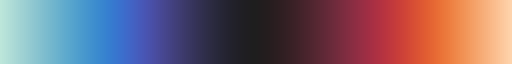

In [40]:
sns.color_palette("icefire", as_cmap=True)


In [41]:
colors_cont = sns.color_palette("icefire", as_cmap=True)


## Distribuição e Evolução de Avaliações

Vamos inicializar nossa análise investigando a distribuição e evolução histórica das avaliações.

<AxesSubplot:xlabel='review_score', ylabel='Count'>

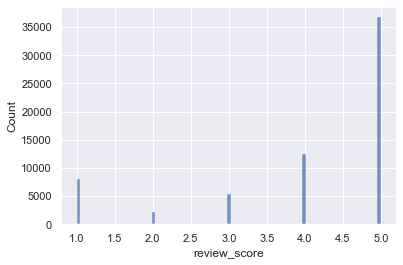

In [42]:
sns.histplot(data=tb_pedidos, x="review_score")


Como as notas dadas pelos clientes são discretas (de 1 à 5 estrelas provavelmente), nosso histograma se parece mais com um barplot. Para facilitar a leitura vamos utilizar um barplot diretamente:

<AxesSubplot:xlabel='review_score', ylabel='count'>

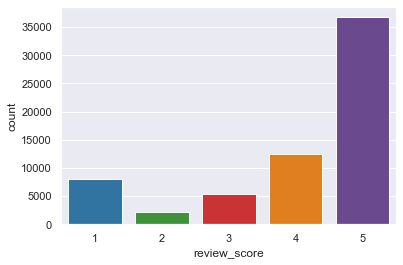

In [43]:
sns.countplot(data=tb_pedidos, x="review_score", palette = colors_discrete_strong)

Podemos ver que existe uma concentração de avaliações nos valores extremos (1 e 5) - vamos agrupar essas notas em duas categorias, marcando as notas 1, 2 e 3 como `detractor`.

In [44]:
tb_pedidos["detractor"] = np.where(tb_pedidos["review_score"] <= 3, 1, 0)


/var/folders/c2/4vv1dtt97gl9bn1lvw8rf0k40000gn/T/ipykernel_45631/2129342268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tb_pedidos["detractor"] = np.where(tb_pedidos["review_score"] <= 3, 1, 0)


Para visualizar a evolução histórica das avaliações precisamos agrupar os pedidos (granularidade do nosso `DataFrame`) em **time buckets**, intervalos de tempo fixos. Vamos utilizar **time buckets** diários para esta análise.

In [45]:
tb_diaria = (
    tb_pedidos.groupby("order_approved_at")
    .agg(
        num_pedidos=pd.NamedAgg("order_id", "nunique"),
        avg_review=pd.NamedAgg("review_score", "mean"),
        std_review=pd.NamedAgg("review_score", "std"),
        per_detractor=pd.NamedAgg("detractor", "mean"),
        per_atraso=pd.NamedAgg("atraso", "mean"),
        avg_atraso=pd.NamedAgg("dias_atraso", "mean"),
    )
    .reset_index()
)


In [46]:
tb_diaria

,order_approved_at,num_pedidos,avg_review,std_review,per_detractor,per_atraso,avg_atraso
0,2017-08-01,93,4.247706,1.270433,0.192661,0.018349,0.137615
1,2017-08-02,161,4.250000,1.207122,0.193182,0.028409,0.380682
2,2017-08-03,120,4.217391,1.242432,0.202899,0.021739,0.159420
3,2017-08-04,102,4.308333,1.043554,0.175000,0.041667,0.400000
4,2017-08-05,97,4.363636,1.163097,0.145455,0.018182,0.081818
...,...,...,...,...,...,...,...
356,2018-07-27,182,4.406250,1.033153,0.133929,0.013393,0.183036
357,2018-07-28,135,4.518750,0.938163,0.118750,0.006250,0.043750
358,2018-07-29,88,4.527473,0.935006,0.087912,0.021978,0.175824
359,2018-07-30,215,4.248945,1.157716,0.160338,0.059072,0.345992


Vamos utilizar diferentes gráficos de linha para avaliar a evolução do número de pedidos, atrasos e avaliações:

<AxesSubplot:xlabel='order_approved_at', ylabel='num_pedidos'>

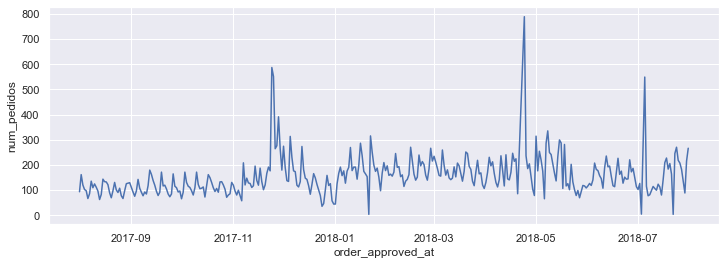

In [49]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=tb_diaria, x="order_approved_at", y="num_pedidos")


<AxesSubplot:xlabel='order_approved_at', ylabel='avg_review'>

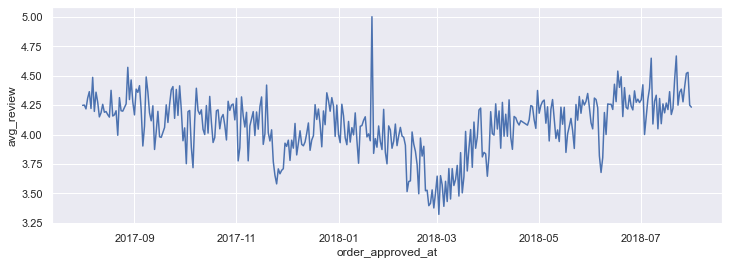

In [50]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=tb_diaria, x="order_approved_at", y="avg_review")


<AxesSubplot:xlabel='order_approved_at', ylabel='per_detractor'>

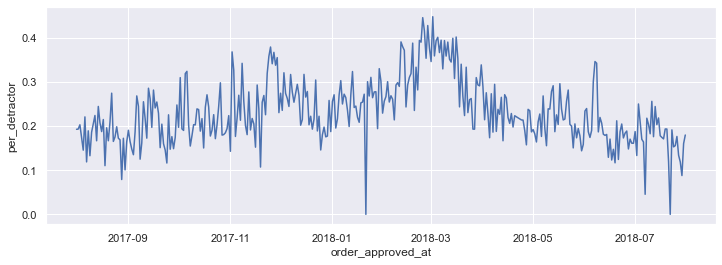

In [51]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=tb_diaria, x="order_approved_at", y="per_detractor")


<AxesSubplot:xlabel='order_approved_at', ylabel='cv_review'>

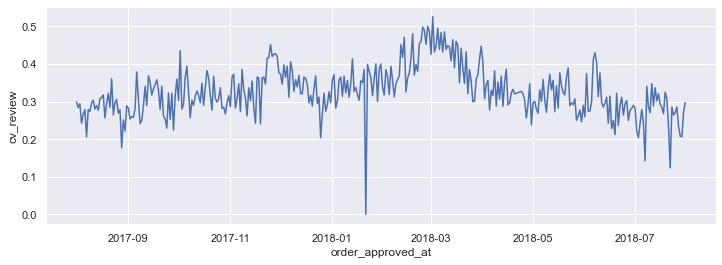

In [52]:
tb_diaria["cv_review"] = tb_diaria["std_review"] / tb_diaria["avg_review"]

plt.figure(figsize=(12, 4))
sns.lineplot(data=tb_diaria, x="order_approved_at", y="cv_review")


<AxesSubplot:xlabel='order_approved_at', ylabel='per_detractor'>

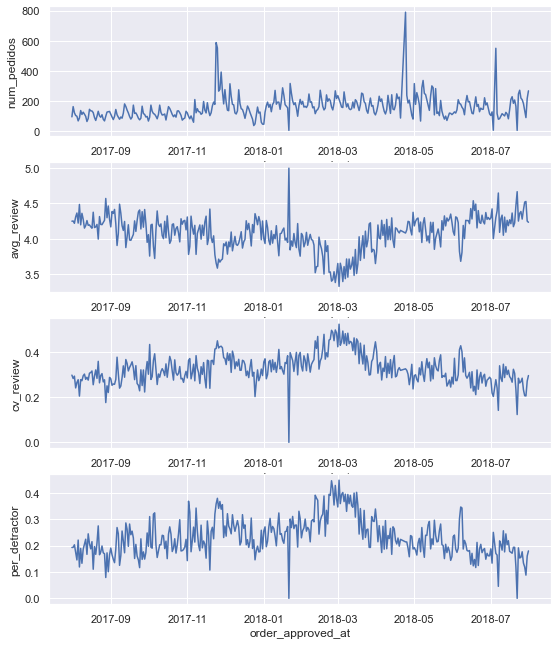

In [55]:
fig, ax = plt.subplots(4, 1, figsize=(9, 11))

sns.lineplot(data=tb_diaria, x="order_approved_at", y="num_pedidos", ax=ax[0])
sns.lineplot(data=tb_diaria, x="order_approved_at", y="avg_review", ax=ax[1])
sns.lineplot(data=tb_diaria, x="order_approved_at", y="cv_review", ax=ax[2])
sns.lineplot(data=tb_diaria, x="order_approved_at", y="per_detractor", ax=ax[3])


Embora a análise das séries diárias nos permita ver fenômenos como a sazonalidade de dia da semana e eventuais outliers, a alta frequência da série pode ocultar padrões mais estáveis. Vamos suaziar estas séries utilizando médias móveis:

In [60]:
tb_diaria["mm_num_pedidos"] = tb_diaria["num_pedidos"].rolling(7).mean()
tb_diaria["mm_avg_review"] = tb_diaria["avg_review"].rolling(7).mean()
tb_diaria["mm_cv_review"] = tb_diaria["cv_review"].rolling(7).mean()
tb_diaria["mm_per_detractor"] = tb_diaria["per_detractor"].rolling(7).mean()
tb_diaria["mm_per_atraso"] = tb_diaria["per_atraso"].rolling(7).mean()
tb_diaria.head(10)


,order_approved_at,num_pedidos,avg_review,std_review,per_detractor,per_atraso,avg_atraso,cv_review,mm_num_pedidos,mm_avg_review,mm_cv_review,mm_per_detractor,mm_per_atraso
0,2017-08-01,93,4.247706,1.270433,0.192661,0.018349,0.137615,0.299087,NaN,NaN,NaN,NaN,NaN
1,2017-08-02,161,4.250000,1.207122,0.193182,0.028409,0.380682,0.284029,NaN,NaN,NaN,NaN,NaN
2,2017-08-03,120,4.217391,1.242432,0.202899,0.021739,0.159420,0.294597,NaN,NaN,NaN,NaN,NaN
3,2017-08-04,102,4.308333,1.043554,0.175000,0.041667,0.400000,0.242218,NaN,NaN,NaN,NaN,NaN
4,2017-08-05,97,4.363636,1.163097,0.145455,0.018182,0.081818,0.266543,NaN,NaN,NaN,NaN,NaN
5,2017-08-06,66,4.220779,1.176786,0.220779,0.025974,0.272727,0.278808,NaN,NaN,NaN,NaN,NaN
6,2017-08-07,85,4.485149,0.923189,0.118812,0.019802,0.108911,0.205832,103.428571,4.298999,0.267302,0.178398,0.024874
7,2017-08-08,135,4.195946,1.170259,0.189189,0.027027,0.182432,0.278902,109.428571,4.291605,0.264418,0.177902,0.026114
8,2017-08-09,109,4.359375,1.195361,0.132812,0.023438,0.406250,0.274205,102.000000,4.307230,0.263015,0.169278,0.025404
9,2017-08-10,124,4.275862,1.266462,0.186207,0.041379,0.324138,0.296189,102.571429,4.315583,0.263242,0.166893,0.028210


Agora vamos combinar as visualizações que construímos anteriormente (da visão diária) com as novas variáveis que construímos (médias móveis):

<AxesSubplot:xlabel='order_approved_at', ylabel='per_atraso'>

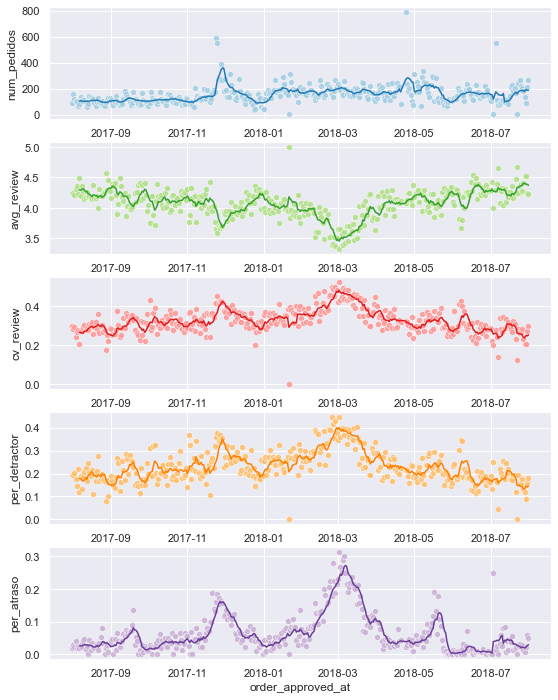

In [61]:
fig, ax = plt.subplots(5, 1, figsize=(9, 12))

sns.scatterplot(
    data=tb_diaria,
    x="order_approved_at",
    y="num_pedidos",
    color=colors_discrete[0],
    ax=ax[0],
    alpha=0.9,
)
sns.lineplot(
    data=tb_diaria,
    x="order_approved_at",
    y="mm_num_pedidos",
    color=colors_discrete[1],
    ax=ax[0],
)

sns.scatterplot(
    data=tb_diaria,
    x="order_approved_at",
    y="avg_review",
    color=colors_discrete[2],
    ax=ax[1],
    alpha=0.9,
)
sns.lineplot(
    data=tb_diaria,
    x="order_approved_at",
    y="mm_avg_review",
    color=colors_discrete[3],
    ax=ax[1],
)
sns.scatterplot(
    data=tb_diaria,
    x="order_approved_at",
    y="cv_review",
    color=colors_discrete[4],
    ax=ax[2],
    alpha=0.9,
)
sns.lineplot(
    data=tb_diaria,
    x="order_approved_at",
    y="mm_cv_review",
    color=colors_discrete[5],
    ax=ax[2],
)
sns.scatterplot(
    data=tb_diaria,
    x="order_approved_at",
    y="per_detractor",
    color=colors_discrete[6],
    ax=ax[3],
    alpha=0.9,
)
sns.lineplot(
    data=tb_diaria,
    x="order_approved_at",
    y="mm_per_detractor",
    color=colors_discrete[7],
    ax=ax[3],
)
sns.scatterplot(
    data=tb_diaria,
    x="order_approved_at",
    y="per_atraso",
    color=colors_discrete[8],
    ax=ax[4],
    alpha=0.9,
)
sns.lineplot(
    data=tb_diaria,
    x="order_approved_at",
    y="mm_per_atraso",
    color=colors_discrete[9],
    ax=ax[4],
)


## Explorando (co)Relações

Através da **análise de séries temporais** conseguimos encontrar correlações temporais (no nível diário, não do pedido) entre alguns indicadores agregados. Vamos avaliar essas relações mais de perto utilizando *scatterplots* para **visualizar diretamente a estrutura de correlação** entre nossas variáveis temporais.

<AxesSubplot:xlabel='num_pedidos', ylabel='avg_review'>

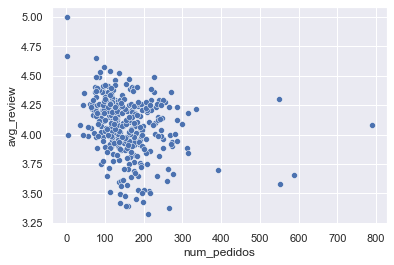

In [72]:
sns.scatterplot(data=tb_diaria, x="num_pedidos", y="avg_review")


<AxesSubplot:xlabel='mm_num_pedidos', ylabel='mm_avg_review'>

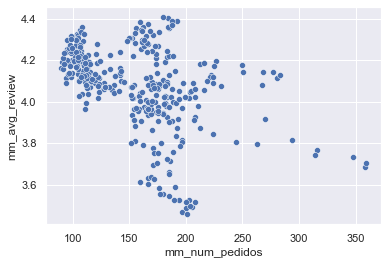

In [63]:
sns.scatterplot(data=tb_diaria, x="mm_num_pedidos", y="mm_avg_review")


Vamos utilizar o elemento cor para representar a taxa de atraso, permitindo visualizarmos a relação entre 3 variáveis diretamente:

<AxesSubplot:xlabel='mm_num_pedidos', ylabel='mm_avg_review'>

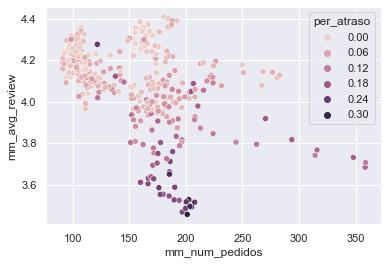

In [64]:
sns.scatterplot(data=tb_diaria, x="mm_num_pedidos", y="mm_avg_review", hue="per_atraso")


Uma deficiência dos scatterplots é o **empilhamento de pontos**, que muitas vezes dificulta a visualização de regiões com maior densidade de pontos. Vamos utilizar a função `kdeplot()` para representar curvas de nível da densidade de pontos.

<AxesSubplot:xlabel='mm_per_atraso', ylabel='mm_avg_review'>

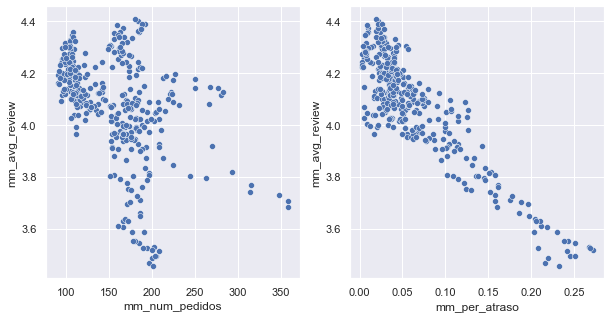

In [76]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.scatterplot(data=tb_diaria, x="mm_num_pedidos", y="mm_avg_review", ax = ax[0])
sns.scatterplot(data=tb_diaria, x="mm_per_atraso", y="mm_avg_review", ax = ax[1])

## Relação entre uma variável continua e uma categórica

Agora vamos retornar à nossa base original, no nível linha do pedido, para analisarmos quais fatores discretos impactam a **% de atrasos** observada.

In [77]:
tb_pedidos = tb_pedidos.merge(
    tb_diaria[["order_approved_at", "num_pedidos"]], on="order_approved_at"
)


In [78]:
tb_pedidos.head()

,order_id,seller_id,price,freight_value,order_status,order_approved_at,shipping_limit_date,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_state,seller_state,product_category_name,product_weight_g,review_score,atraso,dias_atraso,detractor,num_pedidos
0,02852b112ad108b3d2b3d4ee198d84a8,54965bbe3e4f07ae045b90b0b8541f52,69.90,50.15,delivered,2017-11-26,2017-11-30,2018-01-04,2018-01-13,2017-12-22,BA,PR,cama_mesa_banho,4850.0,1,True,22.0,1,264
1,012bea13f9a355c983efb59a3f23583a,db4350fd57ae30082dec7acbaacc17f9,21.99,15.10,delivered,2017-11-26,2017-11-30,2017-11-27,2017-12-15,2017-12-27,RS,SP,telefonia,100.0,5,False,0.0,0,264
2,0204196a1fd266bdc00356eb791b4516,1f50f920176fa81dab994f9023523100,49.00,17.64,delivered,2017-11-26,2017-11-30,2017-11-30,2017-12-12,2017-12-18,MG,SP,ferramentas_jardim,1550.0,5,False,0.0,0,264
3,0204196a1fd266bdc00356eb791b4516,1f50f920176fa81dab994f9023523100,49.00,17.64,delivered,2017-11-26,2017-11-30,2017-11-30,2017-12-12,2017-12-18,MG,SP,ferramentas_jardim,1550.0,5,False,0.0,0,264
4,01c2c8708930c4fb8ed278dfe7ec93c7,f262cbc1c910c83959f849465454ddd3,239.99,17.44,delivered,2017-11-26,2017-11-30,2017-11-27,2017-11-30,2017-12-19,SC,SP,informatica_acessorios,525.0,5,False,0.0,0,264


Vamos começar analisando a distribuição de peso dos itens comprados pela categorização de avaliação que fizemos:

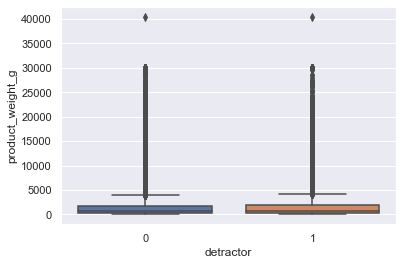

In [80]:
sns.boxplot(
    data=tb_pedidos,
    x="detractor",
    y="product_weight_g",
);


Que gráfico horrível! Sempre que observamos uma variável (estritamente positiva) cuja distribuição está muito concentrada em valores baixos mas com muitos outliers, podemos considerar uma transformação logaritmíca para facilitar a visualização dos resultados:

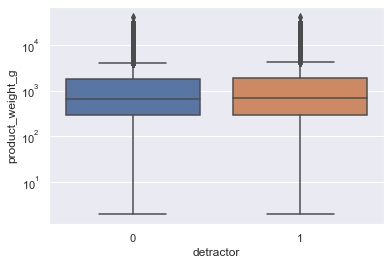

In [81]:
g = sns.boxplot(
    data=tb_pedidos[tb_pedidos["product_weight_g"] > 0],
    x="detractor",
    y="product_weight_g",
)
g.set_yscale("log")


Parece que o peso do item comprado não tem impacto sobre a avaliação... Testar variável a variável desta forma pode ser trabalhoso e nem sempre renderá avanços no nosso modelo. Vamos utilizar uma técnica reminescente das regressões lineares para facilitar nossa exploração: a **análise de resíduos (ou erros)**.

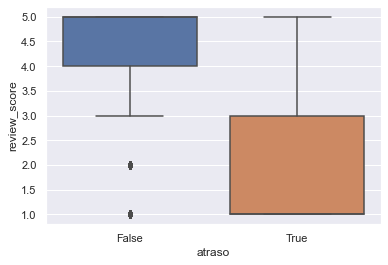

In [85]:
g = sns.boxplot(data=tb_pedidos, x="atraso", y="review_score");


Claramente o *status* de atraso tem um impacto enorme nas avaliações, mas isso já era um fato conhecido! No entanto temos pedidos com avaliações <= 3 sem que houvesse atraso. Vamos criar uma base filtrada para buscar outros fatores que podem impactar a avaliação do cliente:

In [102]:
tb_pedidos.head()

,order_id,seller_id,price,freight_value,order_status,order_approved_at,shipping_limit_date,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_state,seller_state,product_category_name,product_weight_g,review_score,atraso,dias_atraso,detractor,num_pedidos,cat_agg
0,02852b112ad108b3d2b3d4ee198d84a8,54965bbe3e4f07ae045b90b0b8541f52,69.90,50.15,delivered,2017-11-26,2017-11-30,2018-01-04,2018-01-13,2017-12-22,BA,PR,cama_mesa_banho,4850.0,1,True,22.0,1,264,cama_mesa_banho
1,012bea13f9a355c983efb59a3f23583a,db4350fd57ae30082dec7acbaacc17f9,21.99,15.10,delivered,2017-11-26,2017-11-30,2017-11-27,2017-12-15,2017-12-27,RS,SP,telefonia,100.0,5,False,0.0,0,264,Outros
2,0204196a1fd266bdc00356eb791b4516,1f50f920176fa81dab994f9023523100,49.00,17.64,delivered,2017-11-26,2017-11-30,2017-11-30,2017-12-12,2017-12-18,MG,SP,ferramentas_jardim,1550.0,5,False,0.0,0,264,Outros
3,0204196a1fd266bdc00356eb791b4516,1f50f920176fa81dab994f9023523100,49.00,17.64,delivered,2017-11-26,2017-11-30,2017-11-30,2017-12-12,2017-12-18,MG,SP,ferramentas_jardim,1550.0,5,False,0.0,0,264,Outros
4,01c2c8708930c4fb8ed278dfe7ec93c7,f262cbc1c910c83959f849465454ddd3,239.99,17.44,delivered,2017-11-26,2017-11-30,2017-11-27,2017-11-30,2017-12-19,SC,SP,informatica_acessorios,525.0,5,False,0.0,0,264,informatica_acessorios


In [87]:
~tb_pedidos["atraso"]

0        False
1         True
2         True
3         True
4         True
         ...  
64873     True
64874    False
64875     True
64876     True
64877     True
Name: atraso, Length: 64878, dtype: bool

In [88]:
mask_out = (~tb_pedidos["atraso"]) & (tb_pedidos["review_score"] <= 3)
tb_pedidos_out = tb_pedidos[mask_out].copy()


Além do atraso, um eixo comum de reclamação é a **qualidade dos produtos** pedidos. Vamos descobrir se existem categorias ofensoras dentro do nosso grupo de pedidos mal-avaliados sem atraso:

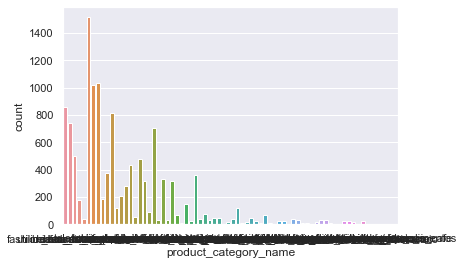

In [89]:
sns.countplot(data=tb_pedidos_out, x="product_category_name");


O que está errado com esse gráfico?

In [94]:
tb_cat_out = (
    tb_pedidos_out.groupby("product_category_name")["order_id"]
    .count()
    .reset_index()
    .rename({"order_id": "num_pedidos_out"}, axis=1)
)

tb_cat = (
    tb_pedidos.groupby("product_category_name")["order_id"]
    .count()
    .reset_index()
    .rename({"order_id": "num_pedidos_total"}, axis=1)
)

tb_cat = tb_cat.merge(tb_cat_out, on="product_category_name")

tb_cat["prop_total"] = tb_cat["num_pedidos_total"] / sum(tb_cat["num_pedidos_total"])
tb_cat["num_pedidos_out_expct"] = tb_cat["prop_total"] * sum(tb_cat["num_pedidos_out"])
tb_cat["diff_pedidos_out"] = tb_cat["num_pedidos_out"] - tb_cat["num_pedidos_out_expct"]

tb_cat.head()

,product_category_name,num_pedidos_total,num_pedidos_out,prop_total,num_pedidos_out_expct,diff_pedidos_out
0,,857,186,0.013211,161.034300,24.965700
1,agro_industria_e_comercio,133,23,0.002050,24.991321,-1.991321
2,alimentos,245,39,0.003777,46.036644,-7.036644
3,alimentos_bebidas,172,32,0.002652,32.319603,-0.319603
4,artes,117,25,0.001804,21.984846,3.015154


Agora podemos visualizar se existem categorias cujo # de pedidos dentro do grupo selecionado (sem atraso) é maior do que o esperado:

<AxesSubplot:xlabel='diff_pedidos_out', ylabel='Count'>

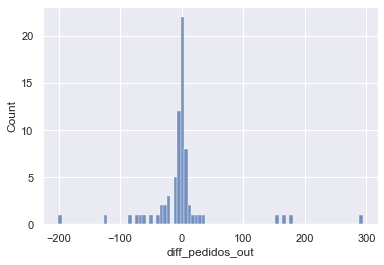

In [95]:
sns.histplot(data=tb_cat, x="diff_pedidos_out")


Temos algumas ofensoras claras! Vamos filtrar a tabela acima e selecionar estas categorias:

In [98]:
cat_problema = set(
    tb_cat.loc[tb_cat["diff_pedidos_out"] > 100, "product_category_name"]
)
cat_problema


{'cama_mesa_banho',
 'informatica_acessorios',
 'moveis_decoracao',
 'moveis_escritorio'}

Agora vamos utilizar esse conjunto de categorias para realizar um agrupamento da variável categoria na base original de pedidos:

In [99]:
mask_cat = tb_pedidos["product_category_name"].map(lambda x: x in cat_problema)
mask_cat

0         True
1        False
2        False
3        False
4         True
         ...  
64873     True
64874     True
64875    False
64876    False
64877    False
Name: product_category_name, Length: 64878, dtype: bool

<AxesSubplot:xlabel='atraso', ylabel='review_score'>

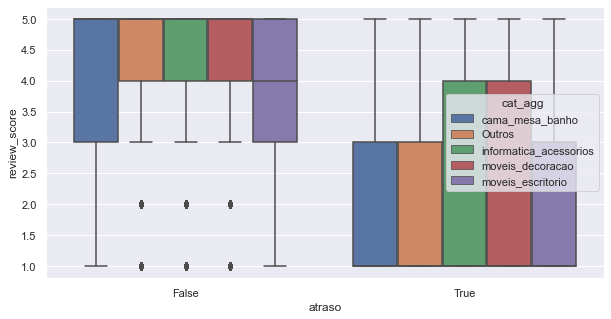

In [100]:
mask_cat = tb_pedidos["product_category_name"].map(lambda x: x in cat_problema)

tb_pedidos.loc[mask_cat, "cat_agg"] = tb_pedidos["product_category_name"]

tb_pedidos.loc[~mask_cat, "cat_agg"] = "Outros"
fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(data=tb_pedidos, x="atraso", y="review_score", hue="cat_agg")


A natureza discreta do campo de avaliação dificulta a visualização da distribuição através de boxplots. Vamos utilizar um violin plot para aumentar a

<AxesSubplot:xlabel='cat_agg', ylabel='review_score'>

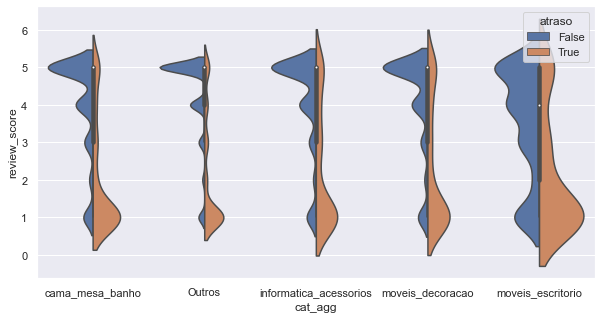

In [101]:
fig = plt.figure(figsize=(10, 5))
sns.violinplot(data=tb_pedidos, x="cat_agg", y="review_score", hue="atraso", split=True)


## Análises multi-variáveis

In [103]:
tb_diaria.columns


Index(['order_approved_at', 'num_pedidos', 'avg_review', 'std_review',
       'per_detractor', 'per_atraso', 'avg_atraso', 'cv_review',
       'mm_num_pedidos', 'mm_avg_review', 'mm_cv_review', 'mm_per_detractor',
       'mm_per_atraso'],
      dtype='object')

In [104]:
var_original = [
    "num_pedidos",
    "avg_review",
    "std_review",
    "per_detractor",
    "per_atraso",
    "avg_atraso",
]
var_mm = ["mm_num_pedidos", "mm_avg_review", "mm_cv_review", "mm_per_detractor"]


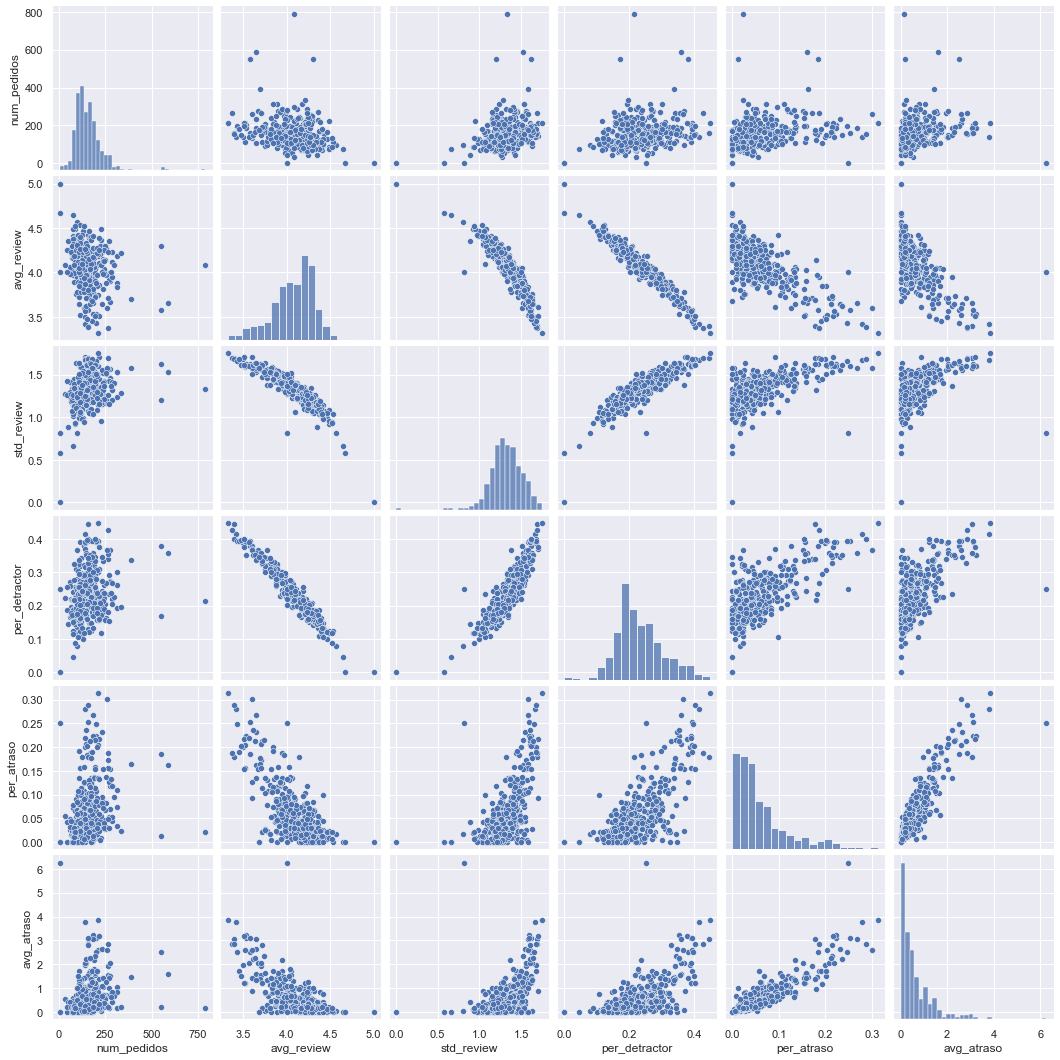

In [105]:
sns.pairplot(tb_diaria[var_original])


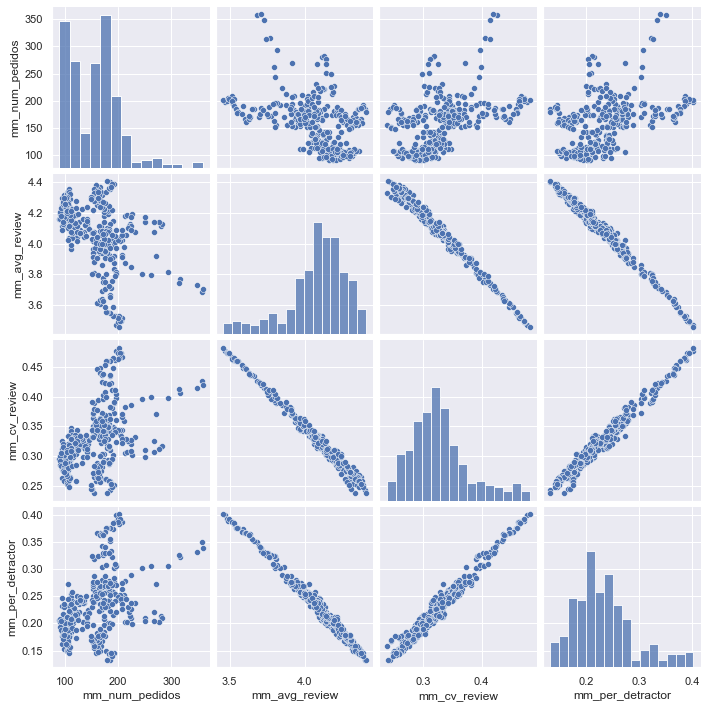

In [106]:
sns.pairplot(tb_diaria[var_mm])


In [108]:
tb_diaria[var_original].corr()

,num_pedidos,avg_review,std_review,per_detractor,per_atraso,avg_atraso
num_pedidos,1.000000,-0.270249,0.295763,0.258474,0.271179,0.228716
avg_review,-0.270249,1.000000,-0.900537,-0.971314,-0.734777,-0.676987
std_review,0.295763,-0.900537,1.000000,0.871522,0.594405,0.507405
per_detractor,0.258474,-0.971314,0.871522,1.000000,0.701850,0.646308
per_atraso,0.271179,-0.734777,0.594405,0.701850,1.000000,0.899903
avg_atraso,0.228716,-0.676987,0.507405,0.646308,0.899903,1.000000


<AxesSubplot:>

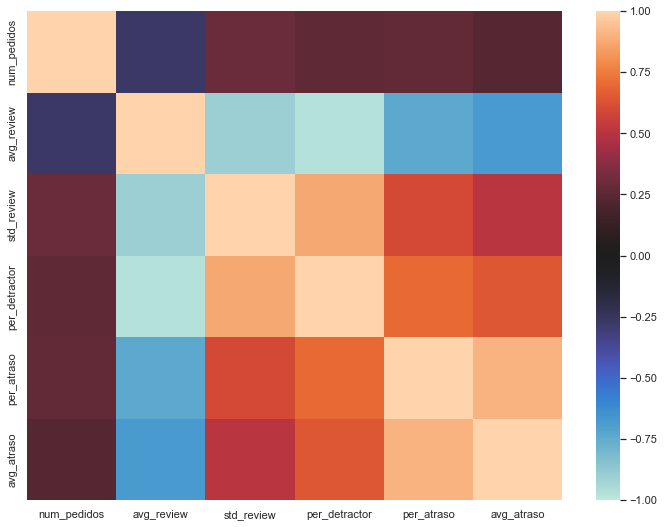

In [110]:
plt.figure(figsize=(12, 9))
sns.heatmap(tb_diaria[var_original].corr(), vmin=-1, center=0, vmax=1)


<Figure size 864x648 with 0 Axes>

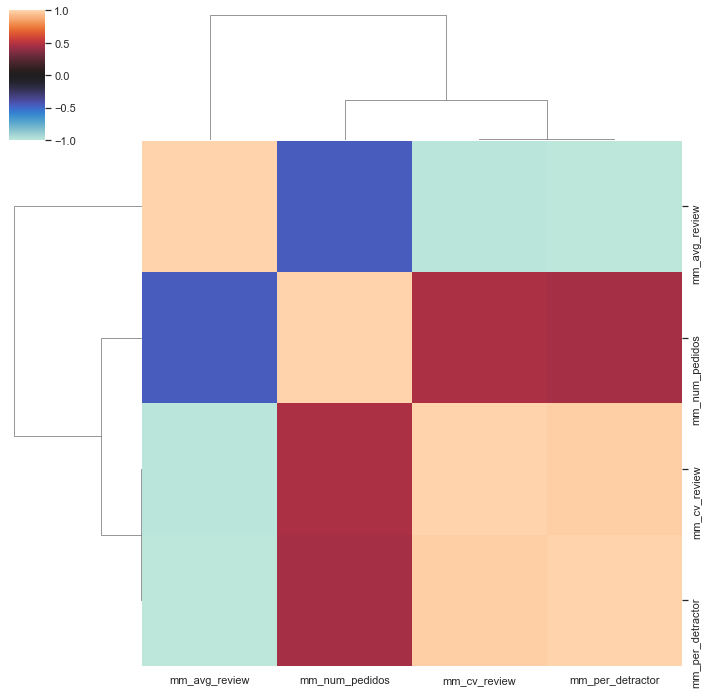

In [113]:
plt.figure(figsize=(12, 9))
sns.clustermap(tb_diaria[var_mm].corr(), vmin=-1, center=0, vmax=1)
